## Single SED Example

---

### Imports

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import warnings
import corner
from astropy.constants import c
warnings.filterwarnings('ignore')
utils.rcparams()

---

### Example SPT Source

In [2]:
# Example data
object_id = 'SPT 0002-52'
wavelengths_obs_um = np.array([100,160,250,350,500,870,1400,2000,3000])
fluxes = np.array([93.9,234.3,332.9,283.5,202,50.3,10.7,3.1,0.47])/1000
flux_errors = np.array([5.4,21.3,10.1,8.9,10,3.8,5.8,0.9,0.03])/1000
calibrations = np.array([7,7,5.5,5.5,5.5,12,7,7,10])
magnification = 5.5
redshift = 2.351
wavelengths_rest_um = wavelengths_obs_um/(1+redshift)

# General Opacity - 100 microns
example_spt_go100 = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_spt_go100(opacity_model="fixed_wave", fixparams=['lambda_thick'], fixvalues=[100], verbose=True)

# General Opacity - 200 microns
example_spt_go200 = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_spt_go200(opacity_model="fixed_wave", fixparams=['lambda_thick'], fixvalues=[200], verbose=True)

# Optically Thin
example_spt_ot = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_spt_ot(opacity_model="thin", verbose=True)

100%|██████████| 2000/2000 [00:52<00:00, 38.13it/s]


In [3]:
# Fitting results
print(example_spt_go100.results_summary())
print(example_spt_go200.results_summary())
print(example_spt_ot.results_summary())

{'id': 'SPT 0002-52', 'z': 2.351, 'logm_low': 0.05561751538132853, 'logm': 8.797671691848683, 'logm_high': 0.0509573799954115, 't_low': 2.540386872558841, 't': 43.54671803604619, 't_high': 3.184583302116444, 'beta_low': 0.09604807481708089, 'beta': 1.9722209336767067, 'beta_high': 0.09624402772251273, 'lambda_thick_low': 0.0, 'lambda_thick': 100.0, 'lambda_thick_high': 0.0, 'r_low': 0.08750312964843954, 'r': 0.7424141053710396, 'r_high': 0.08944044401542295, 'chi': 11.472206821457595, 'chi_red': 2.294441364291519, 'logmulir_low': 0.027734950821376003, 'logmulir': 14.003092513202382, 'logmulir_high': 0.02738848008165995, 'logmulfir_low': 0.018126825993421747, 'logmulfir': 13.712396261050872, 'logmulfir_high': 0.02003812550383266, 'loglir_low': 0.027734950821376003, 'loglir': 13.262729823708138, 'loglir_high': 0.02738848008165995, 'loglfir_low': 0.018126825993421747, 'loglfir': 12.972033571556628, 'loglfir_high': 0.02003812550383266, 'logmum_low': 0.05561751538132853, 'logmum': 9.5380343

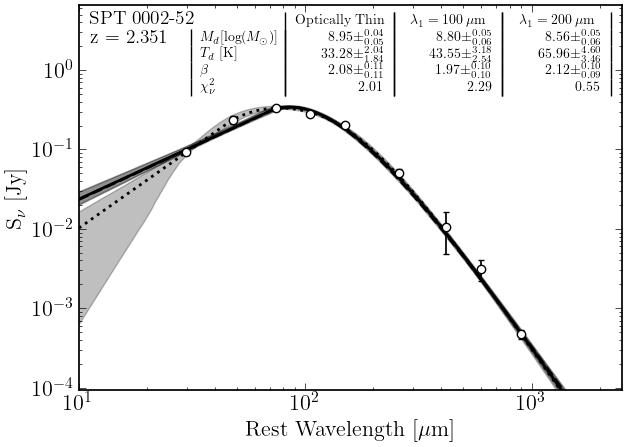

In [4]:
# Get best parameters
best_parameters_go200 = example_spt_go200.best_params
best_parameters_go100 = example_spt_go100.best_params
best_parameters_ot = example_spt_ot.best_params

# Generate frequency range for plot
wave_range_obs_um = np.linspace(5,50000,100000)
wave_range_obs_m = wave_range_obs_um*1e-6
wave_range_rest_um = wave_range_obs_um/(1+example_spt_ot.redshift)
wave_range_rest_m = wave_range_obs_m/(1+example_spt_ot.redshift)
frequency_range_rest = c.value/wave_range_rest_m

fig, ax = plt.subplots(figsize=(7,5))

# Plot of the best fitting SEDs
ax.plot(wave_range_rest_um, example_spt_ot.sed(frequency_range_rest, example_spt_ot.best_theta), lw=2, color='k')
ax.plot(wave_range_rest_um, example_spt_go100.sed(frequency_range_rest, example_spt_go100.best_theta), lw=2, linestyle='--', color='k')
ax.plot(wave_range_rest_um, example_spt_go200.sed(frequency_range_rest, example_spt_go200.best_theta), lw=2, linestyle=':', color='k')

# Sample the parameter space
sample_thetas_ot, _ = example_spt_ot.sample_walkers(500)
sample_thetas_go100, _ = example_spt_go100.sample_walkers(500)
sample_thetas_go200, _ = example_spt_go200.sample_walkers(500)

# Plot samples showing error ranges
ot_low, ot_high = np.percentile([example_spt_ot.sed(frequency_range_rest, theta) for theta in sample_thetas_ot], [16,84], axis=0)
go100_low, go100_high = np.percentile([example_spt_go100.sed(frequency_range_rest, theta) for theta in sample_thetas_go100], [16,84], axis=0)
go200_low, go200_high = np.percentile([example_spt_go200.sed(frequency_range_rest, theta) for theta in sample_thetas_go200], [16,84], axis=0)
ax.fill_between(wave_range_rest_um, ot_high, ot_low, color='k', alpha=0.25)
ax.fill_between(wave_range_rest_um, go100_high, go100_low, color='k', alpha=0.25)
ax.fill_between(wave_range_rest_um, go200_high, go200_low, color='k', alpha=0.25)

# Add error bars and a table of results
ax.errorbar(example_spt_ot.wavelength_rest_um, example_spt_ot.flux_jy, yerr=example_spt_ot.fluxerr_jy, color='k', fmt='o')
col_labels=[r'$\textrm{Optically Thin}$', r'$\lambda_1 = 100\,\mu$m', r'$\lambda_1 = 200\,\mu$m']
row_labels=[r'$M_d [\textrm{log}(M_\odot)]$', r'$T_d$ [K]', r'$\beta$', r'$\chi_\nu^2$']
table_vals=[[r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['log_m'][1],best_parameters_ot['log_m'][2],best_parameters_ot['log_m'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['log_m'][1],best_parameters_go100['log_m'][2],best_parameters_go100['log_m'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['log_m'][1],best_parameters_go200['log_m'][2],best_parameters_go200['log_m'][0])],
            [r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['t'][1],best_parameters_ot['t'][2],best_parameters_ot['t'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['t'][1],best_parameters_go100['t'][2],best_parameters_go100['t'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['t'][1],best_parameters_go200['t'][2],best_parameters_go200['t'][0])],
            [r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['beta'][1],best_parameters_ot['beta'][2],best_parameters_ot['beta'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['beta'][1],best_parameters_go100['beta'][2],best_parameters_go100['beta'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['beta'][1],best_parameters_go200['beta'][2],best_parameters_go200['beta'][0])],
            [r'%.2f' % example_spt_ot.reduced_chi_squared(),
             r'%.2f' % example_spt_go100.reduced_chi_squared(),
             r'%.2f' % example_spt_go200.reduced_chi_squared()]]
the_table = ax.table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='upper right',
                  fontsize=10,
                  edges='vertical')
ax.text(0.02,0.9,'\n'.join((example_spt_ot.name,r'z = %.3f' % example_spt_ot.redshift)),fontsize=14,transform=ax.transAxes)
ax.set_xlim(10, 2500)
ax.set_ylim(min(fluxes)/5, max(fluxes)*20)
ax.set_xlabel(r'Rest Wavelength [$\mu$m]')
ax.set_ylabel(r'S$_\nu$ [Jy]')
ax.loglog()
plt.savefig(utils.ROOT + '/figures/Figure_not_used_1.pdf', dpi=1000)
plt.show()

In [5]:
# Select labels for corner plot
labels_get = ['log_m', 't', 'beta', 'log_LIR', 'peak_wave']
labels = [r'log($M_\textrm{dust}$ [$M_\odot$])', r'$T_\textrm{dust}$ [K]', r'$\beta$', r'log($L_{\textrm{IR}}$ [$L_\odot$])', r'$\lambda_\textrm{peak}$ [$\mu$m]']

# Indexes for the parameters in each model
spt_ot_index = [example_spt_ot.params_full_vary.index(param) for param in labels_get]
spt_go100_index = [example_spt_go100.params_full_vary.index(param) for param in labels_get]
spt_go200_index = [example_spt_go200.params_full_vary.index(param) for param in labels_get]

# Obtain the full samples
example_spt_ot_samples = np.array([[list_[it] for list_ in example_spt_ot.sample_full_vary] for it in spt_ot_index]).T
example_spt_go100_samples = np.array([[list_[it] for list_ in example_spt_go100.sample_full_vary] for it in spt_go100_index]).T
example_spt_go200_samples = np.array([[list_[it] for list_ in example_spt_go200.sample_full_vary] for it in spt_go200_index]).T

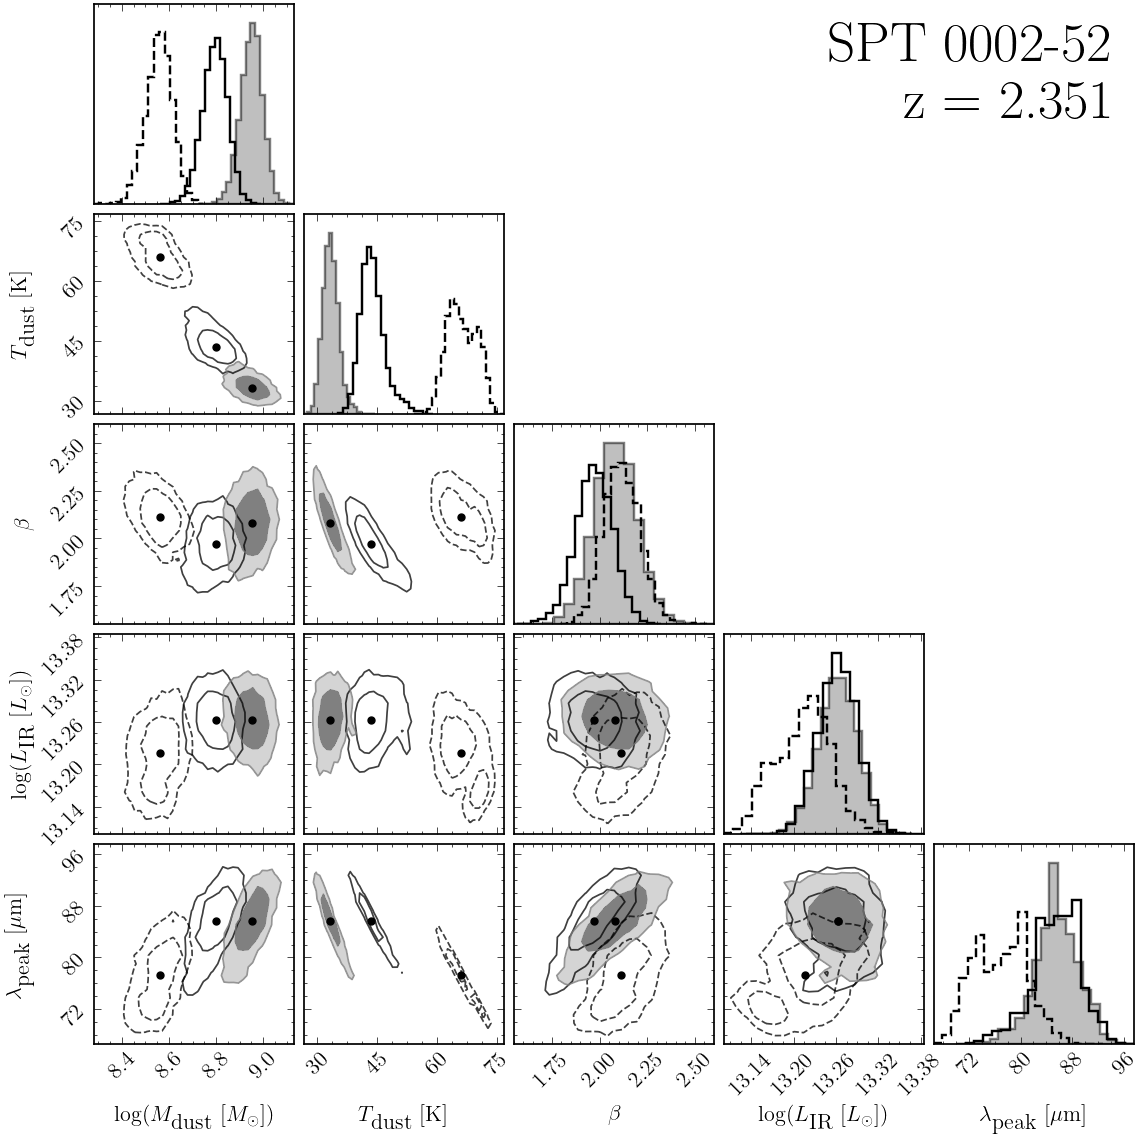

In [6]:
# Corner plot for each model
fig = corner.corner(example_spt_go100_samples, labels=labels, levels=[0.68, 0.95], fill_contours=False, plot_density=False, color='k', contour_kwargs={'linestyles': '-', 'alpha': 0.75}, hist_kwargs={'histtype': 'step', 'linestyle': '-', 'ec': 'k', 'fc': 'w', 'linewidth': 1.75, 'alpha': 1})
corner.corner(example_spt_go200_samples, fig=fig, labels=labels, levels=[0.68, 0.95], fill_contours=False, plot_density=False, color='k', contour_kwargs={'linestyles': '--', 'alpha': 0.75}, hist_kwargs={'histtype': 'step', 'linestyle': '--', 'ec': 'k', 'fc': 'w', 'linewidth': 1.75, 'alpha': 1})
corner.corner(example_spt_ot_samples, labels=labels, fig=fig, levels=[0.68, 0.95], fill_contours=True, plot_density=False, color='gray', contour_kwargs={'linestyles': '-', 'alpha': 0.75}, hist_kwargs={'histtype': 'stepfilled', 'linestyle': '-', 'ec': 'k', 'fc': 'gray', 'linewidth': 1.75, 'alpha': 0.5})

# Plot points at the best fitting model
corner.overplot_points(fig=fig, xs=np.percentile(example_spt_ot_samples, [50], axis=0), mec='k', mfc='k', markersize=10)
corner.overplot_points(fig=fig, xs=np.percentile(example_spt_go100_samples, [50], axis=0), mec='k', mfc='k', markersize=10)
corner.overplot_points(fig=fig, xs=np.percentile(example_spt_go200_samples, [50], axis=0), mec='k', mfc='k', markersize=10)

# Add source name
fig.suptitle('\n'.join((example_spt_ot.name,r'z = %.3f' % example_spt_ot.redshift)), x=0.95, y=0.95, horizontalalignment='right', fontsize=40)

plt.savefig(utils.ROOT + '/figures/Figure_4_4_part1.pdf', dpi=1000)
plt.show()

---

### Example HerBS Source

In [7]:
# Example data
object_id = 'HerBS-11'
wavelengths_obs_um = np.array([250,350,500,850,2000,3000])
fluxes = np.array([257.5,271.1,204,67.3,3.59,0.93])/1000
flux_errors = np.array([6.4,6.3,7.2,6.3,0.03,0.02])/1000
calibrations = np.array([5.5,5.5,5.5,5,10,10])
magnification = 18.4
redshift = 2.631
wavelengths_rest_um = wavelengths_obs_um/(1+redshift)

# General Opacity - 100 microns
example_herbs_go100 = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_herbs_go100(opacity_model="fixed_wave", fixparams=['lambda_thick'], fixvalues=[100], verbose=True)

# General Opacity - 200 microns
example_herbs_go200 = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_herbs_go200(opacity_model="fixed_wave", fixparams=['lambda_thick'], fixvalues=[200], verbose=True)

# Optically Thin
example_herbs_ot = utils.Source(object_id, wavelengths_obs_um, redshift, fluxes, flux_errors, magnification, calibrations)
example_herbs_ot(opacity_model="thin", verbose=True)

100%|██████████| 2000/2000 [00:44<00:00, 44.83it/s]


In [8]:
# Fitting results
print(example_herbs_go100.results_summary())
print(example_herbs_go200.results_summary())
print(example_herbs_ot.results_summary())

{'id': 'HerBS-11', 'z': 2.631, 'logm_low': 0.03923019377471526, 'logm': 8.499825628296378, 'logm_high': 0.03900298032947269, 't_low': 2.0397926081523536, 't': 42.79297602518497, 't_high': 2.2820136672632856, 'beta_low': 0.0799721692639197, 'beta': 1.7840116859032975, 'beta_high': 0.08587837148437627, 'lambda_thick_low': 0.0, 'lambda_thick': 100.0, 'lambda_thick_high': 0.0, 'r_low': 0.04056972508220813, 'r': 0.43002063997329193, 'r_high': 0.04208978765086113, 'chi': 3.5683418719943565, 'chi_red': 1.7841709359971782, 'logmulir_low': 0.03988293662303022, 'logmulir': 13.732510267151202, 'logmulir_high': 0.18857632047409467, 'logmulfir_low': 0.025006407908843897, 'logmulfir': 13.68939216813107, 'logmulfir_high': 0.03288180631457571, 'loglir_low': 0.03988293662303022, 'loglir': 12.467692444141665, 'loglir_high': 0.18857632047409467, 'loglfir_low': 0.025006407908843897, 'loglfir': 12.424574345121533, 'loglfir_high': 0.03288180631457571, 'logmum_low': 0.03923019377471526, 'logmum': 9.764643451

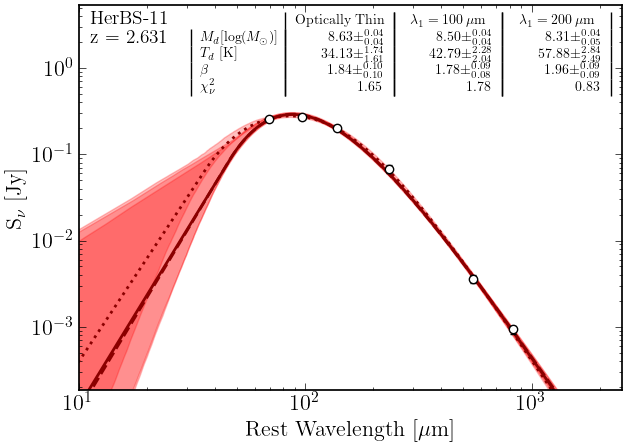

In [9]:
# Get best parameters
best_parameters_go200 = example_herbs_go200.best_params
best_parameters_go100 = example_herbs_go100.best_params
best_parameters_ot = example_herbs_ot.best_params

# Generate frequency range for plot
wave_range_obs_um = np.linspace(5,50000,100000)
wave_range_obs_m = wave_range_obs_um*1e-6
wave_range_rest_um = wave_range_obs_um/(1+example_herbs_ot.redshift)
wave_range_rest_m = wave_range_obs_m/(1+example_herbs_ot.redshift)
frequency_range_rest = c.value/wave_range_rest_m

fig, ax = plt.subplots(figsize=(7,5))

# Plot of the best fitting SEDs
ax.plot(wave_range_rest_um, example_herbs_ot.sed(frequency_range_rest, example_herbs_ot.best_theta), lw=2, color='darkred')
ax.plot(wave_range_rest_um, example_herbs_go100.sed(frequency_range_rest, example_herbs_go100.best_theta), lw=2, linestyle='--', color='darkred')
ax.plot(wave_range_rest_um, example_herbs_go200.sed(frequency_range_rest, example_herbs_go200.best_theta), lw=2, linestyle=':', color='darkred')

# Sample the parameter space
sample_thetas_ot, _ = example_herbs_ot.sample_walkers(500)
sample_thetas_go100, _ = example_herbs_go100.sample_walkers(500)
sample_thetas_go200, _ = example_herbs_go200.sample_walkers(500)

# Plot samples showing error ranges
ot_low, ot_high = np.percentile([example_herbs_ot.sed(frequency_range_rest, theta) for theta in sample_thetas_ot], [16,84], axis=0)
go100_low, go100_high = np.percentile([example_herbs_go100.sed(frequency_range_rest, theta) for theta in sample_thetas_go100], [16,84], axis=0)
go200_low, go200_high = np.percentile([example_herbs_go200.sed(frequency_range_rest, theta) for theta in sample_thetas_go200], [16,84], axis=0)
ax.fill_between(wave_range_rest_um, ot_high, ot_low, color='r', alpha=0.25)
ax.fill_between(wave_range_rest_um, go100_high, go100_low, color='r', alpha=0.25)
ax.fill_between(wave_range_rest_um, go200_high, go200_low, color='r', alpha=0.25)

# Add error bars and a table of results
ax.errorbar(example_herbs_ot.wavelength_rest_um, example_herbs_ot.flux_jy, yerr=example_herbs_ot.fluxerr_jy, color='k', fmt='o')
col_labels=[r'$\textrm{Optically Thin}$', r'$\lambda_1 = 100\,\mu$m', r'$\lambda_1 = 200\,\mu$m']
row_labels=[r'$M_d [\textrm{log}(M_\odot)]$', r'$T_d$ [K]', r'$\beta$', r'$\chi_\nu^2$']
table_vals=[[r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['log_m'][1],best_parameters_ot['log_m'][2],best_parameters_ot['log_m'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['log_m'][1],best_parameters_go100['log_m'][2],best_parameters_go100['log_m'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['log_m'][1],best_parameters_go200['log_m'][2],best_parameters_go200['log_m'][0])],
            [r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['t'][1],best_parameters_ot['t'][2],best_parameters_ot['t'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['t'][1],best_parameters_go100['t'][2],best_parameters_go100['t'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['t'][1],best_parameters_go200['t'][2],best_parameters_go200['t'][0])],
            [r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_ot['beta'][1],best_parameters_ot['beta'][2],best_parameters_ot['beta'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go100['beta'][1],best_parameters_go100['beta'][2],best_parameters_go100['beta'][0]),
             r'%.2f$\pm^{%.2f}_{%.2f}$' % (best_parameters_go200['beta'][1],best_parameters_go200['beta'][2],best_parameters_go200['beta'][0])],
            [r'%.2f' % example_herbs_ot.reduced_chi_squared(),
             r'%.2f' % example_herbs_go100.reduced_chi_squared(),
             r'%.2f' % example_herbs_go200.reduced_chi_squared()]]
the_table = ax.table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='upper right',
                  fontsize=10,
                  edges='vertical')
ax.text(0.02,0.9,'\n'.join((example_herbs_ot.name,r'z = %.3f' % example_herbs_ot.redshift)),fontsize=14,transform=ax.transAxes)
ax.set_xlim(10, 2500)
ax.set_ylim(min(fluxes)/5, max(fluxes)*20)
ax.set_xlabel(r'Rest Wavelength [$\mu$m]')
ax.set_ylabel(r'S$_\nu$ [Jy]')
ax.loglog()
plt.savefig(utils.ROOT + '/figures/Figure_not_used_2.pdf', dpi=1000)
plt.show()


In [10]:
# Select labels for corner plot
labels_get = ['log_m', 't', 'beta', 'log_LIR', 'peak_wave']
labels = [r'log($M_\textrm{dust}$ [$M_\odot$])', r'$T_\textrm{dust}$ [K]', r'$\beta$', r'log($L_{\textrm{IR}}$ [$L_\odot$])', r'$\lambda_\textrm{peak}$ [$\mu$m]']

# Indexes for the parameters in each model
herbs_ot_index = [example_herbs_ot.params_full_vary.index(param) for param in labels_get]
herbs_go100_index = [example_herbs_go100.params_full_vary.index(param) for param in labels_get]
herbs_go200_index = [example_herbs_go200.params_full_vary.index(param) for param in labels_get]

# Obtain the full samples
example_herbs_ot_samples = np.array([[list_[it] for list_ in example_herbs_ot.sample_full_vary] for it in herbs_ot_index]).T
example_herbs_go100_samples = np.array([[list_[it] for list_ in example_herbs_go100.sample_full_vary] for it in herbs_go100_index]).T
example_herbs_go200_samples = np.array([[list_[it] for list_ in example_herbs_go200.sample_full_vary] for it in herbs_go200_index]).T

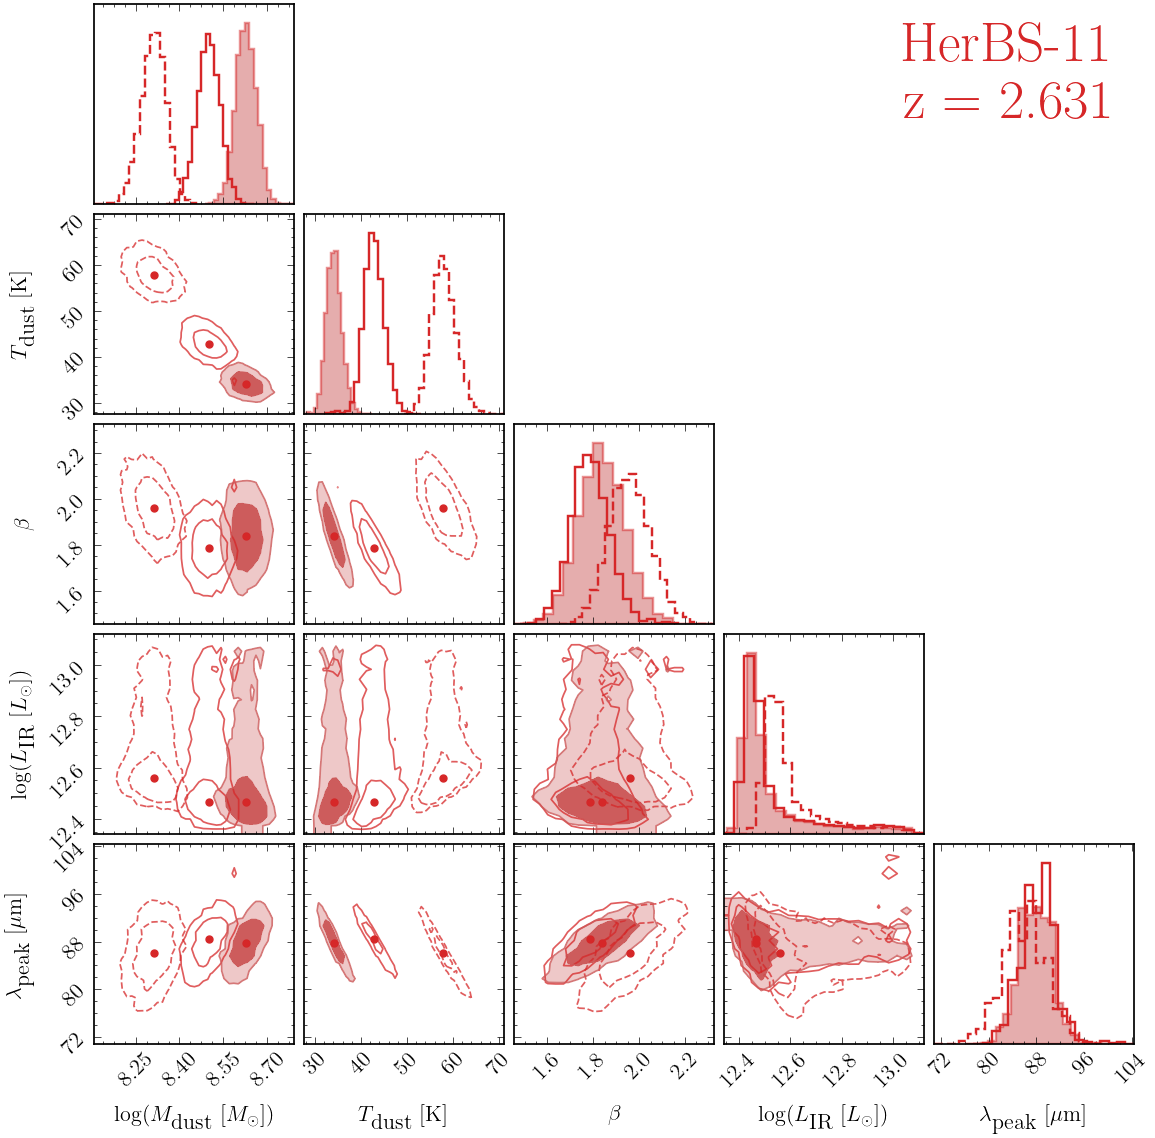

In [11]:
# Corner plot for each model
fig = corner.corner(example_herbs_go100_samples, labels=labels, levels=[0.68, 0.95], fill_contours=False, plot_density=False, color='tab:red', contour_kwargs={'linestyles': '-', 'alpha': 0.75}, hist_kwargs={'histtype': 'step', 'linestyle': '-', 'ec': 'tab:red', 'fc': 'w', 'linewidth': 1.75, 'alpha': 1})
corner.corner(example_herbs_go200_samples, fig=fig, labels=labels, levels=[0.68, 0.95], fill_contours=False, plot_density=False, color='tab:red', contour_kwargs={'linestyles': '--', 'alpha': 0.75}, hist_kwargs={'histtype': 'step', 'linestyle': '--', 'ec': 'tab:red', 'fc': 'w', 'linewidth': 1.75, 'alpha': 1})
corner.corner(example_herbs_ot_samples, labels=labels, fig=fig, levels=[0.68, 0.95], fill_contours=True, plot_density=False, color='indianred', contour_kwargs={'linestyles': '-', 'alpha': 0.75}, hist_kwargs={'histtype': 'stepfilled', 'linestyle': '-', 'ec': 'tab:red', 'fc': 'indianred', 'linewidth': 1.75, 'alpha': 0.5})

# Plot points at the best fitting model
corner.overplot_points(fig=fig, xs=np.percentile(example_herbs_ot_samples, [50], axis=0), mec='tab:red', mfc='tab:red', markersize=10)
corner.overplot_points(fig=fig, xs=np.percentile(example_herbs_go100_samples, [50], axis=0), mec='tab:red', mfc='tab:red', markersize=10)
corner.overplot_points(fig=fig, xs=np.percentile(example_herbs_go200_samples, [50], axis=0), mec='tab:red', mfc='tab:red', markersize=10)

# Add source name
fig.suptitle('\n'.join((example_herbs_ot.name,r'z = %.3f' % example_herbs_ot.redshift)), x=0.95, y=0.95, horizontalalignment='right', fontsize=40, color='tab:red')

plt.savefig(utils.ROOT + '/figures/Figure_4_4_part2.pdf', dpi=1000)
plt.show()